# Thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import csv
import requests
import json

import preprocessing
from preprocessing import *

# Tiền xử lý dữ liệu

Đọc dữ liệu [`vn_news_223_tdlfr.csv`](https://raw.githubusercontent.com/thanhhocse96/VFND-vietnamese-fake-news-datasets/master/CSV/vn_news_223_tdlfr.csv)

In [2]:
!wget https://raw.githubusercontent.com/thanhhocse96/VFND-vietnamese-fake-news-datasets/master/CSV/vn_news_223_tdlfr.csv -O data.csv

--2022-11-25 16:44:34--  https://raw.githubusercontent.com/thanhhocse96/VFND-vietnamese-fake-news-datasets/master/CSV/vn_news_223_tdlfr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 751942 (734K) [text/plain]
Saving to: 'data.csv'

     0K .......... .......... .......... .......... ..........  6%  966K 1s
    50K .......... .......... .......... .......... .......... 13% 1.36M 1s
   100K .......... .......... .......... .......... .......... 20% 1.17M 1s
   150K .......... .......... .......... .......... .......... 27% 1.33M 0s
   200K .......... .......... .......... .......... .......... 34% 4.15M 0s
   250K .......... .......... .......... .......... .......... 40% 2.89M 0s
   300K .......... .......... .......... .......... .......... 47% 2.66M 0

In [3]:
def read_data(csv_file_path):
    f = open(csv_file_path, encoding="utf-8")
    csv_reader = csv.reader(f, delimiter=',')
    line_count = 0
    raw_sentence = []
    raw_domain = []
    raw_label = []
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
            continue
        raw_sentence.append(row[0])
        raw_domain.append(row[1])
        raw_label.append(row[2])
        line_count += 1
    f.close()
    return raw_sentence, raw_domain, raw_label
# raw_doc, raw_domain, raw_label = read_data('data.csv')

Thông tin về dữ liệu

In [4]:
df = pd.read_csv('data.csv')

In [5]:
print(f'Dữ liệu có {df.shape[0]} dòng và {df.shape[1]} cột.')

Dữ liệu có 223 dòng và 3 cột.


In [6]:
print(f'Dữ liệu {"KHÔNG CÓ" if all(df.duplicated()) == False else "CÓ"} dữ liệu trùng.')

Dữ liệu KHÔNG CÓ dữ liệu trùng.


Phân bố các `label`

In [7]:
#x = df['label'].unique()
y = df['label'].value_counts()
y

0    123
1    100
Name: label, dtype: int64

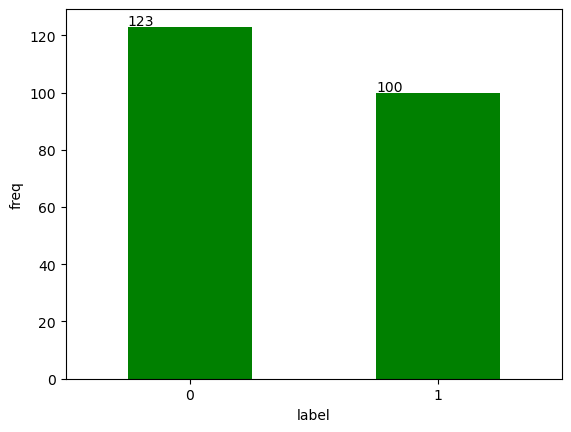

In [8]:
ax = df['label'].value_counts().plot(kind='bar', xlabel="label", ylabel="freq", rot=0, color="green")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## Chuyển về unicode

In [9]:
uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"
vowel_board = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]
bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']

vowel_to_ids = {}

In [10]:
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

In [11]:
def convert_unicode(txt):
    dicchar = loaddicchar()
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

## Chuẩn hóa tiếng Việt

In [12]:
# check if a word is in Vietnamese correct form
def is_valid_vietnam_word(word):
    chars = list(word)
    vowel_index = -1
    for index, char in enumerate(chars):
        x, y = vowel_to_ids.get(char, (-1, -1))
        if x != -1:
            if vowel_index == -1:
                vowel_index = index
            else:
                if index - vowel_index != 1:
                    return False
                vowel_index = index
    return True

In [13]:
# vietnamese punctuation normalize
def vietnamese_word_punctuate_normalization(word):
    if not is_valid_vietnam_word(word):
        return word
 
    chars = list(word)
    dau_cau = 0
    vowel_index = []
    qu_or_gi = False
    for index, char in enumerate(chars):
        x, y = vowel_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            dau_cau = y
            chars[index] = vowel_board[x][0]
        if not qu_or_gi or index != 1:
            vowel_index.append(index)
    if len(vowel_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = vowel_to_ids.get(chars[1])
                chars[1] = vowel_board[x][dau_cau]
            else:
                x, y = vowel_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = vowel_board[x][dau_cau]
                else:
                    chars[1] = vowel_board[5][dau_cau] if chars[1] == 'i' else vowel_board[9][dau_cau]
            return ''.join(chars)
        return word
 
    for index in vowel_index:
        x, y = vowel_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = vowel_board[x][dau_cau]
            # for index2 in vowel_index:
            #     if index2 != index:
            #         x, y = vowel_to_ids[chars[index]]
            #         chars[index2] = vowel_board[x][0]
            return ''.join(chars)
 
    if len(vowel_index) == 2:
        if vowel_index[-1] == len(chars) - 1:
            x, y = vowel_to_ids[chars[vowel_index[0]]]
            chars[vowel_index[0]] = vowel_board[x][dau_cau]
            # x, y = vowel_to_ids[chars[vowel_index[1]]]
            # chars[vowel_index[1]] = vowel_board[x][0]
        else:
            # x, y = vowel_to_ids[chars[vowel_index[0]]]
            # chars[vowel_index[0]] = vowel_board[x][0]
            x, y = vowel_to_ids[chars[vowel_index[1]]]
            chars[vowel_index[1]] = vowel_board[x][dau_cau]
    else:
        # x, y = vowel_to_ids[chars[vowel_index[0]]]
        # chars[vowel_index[0]] = vowel_board[x][0]
        x, y = vowel_to_ids[chars[vowel_index[1]]]
        chars[vowel_index[1]] = vowel_board[x][dau_cau]
        # x, y = vowel_to_ids[chars[vowel_index[2]]]
        # chars[vowel_index[2]] = vowel_board[x][0]
    return ''.join(chars)

In [14]:
# convert sentence to old vietnamese typing
def vietnamese_punctuation_normalization(sentence):
    """
        Chuyển câu tiếng việt về chuẩn gõ dấu kiểu cũ.
        :param sentence:
        :return:
        """
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        # print(cw)
        if len(cw) == 3:
            cw[1] = vietnamese_word_punctuate_normalization(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

## Loại bỏ stopwords

In [15]:
# vietnamese stop-words
# stopwords_url = 'https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords-dash.txt'
!wget https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords-dash.txt -O stopwords.txt

--2022-11-25 16:44:37--  https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords-dash.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20475 (20K) [text/plain]
Saving to: 'stopwords.txt'

     0K .......... .........                                  100% 1.53M=0.01s

2022-11-25 16:44:37 (1.53 MB/s) - 'stopwords.txt' saved [20475/20475]



In [16]:
def read_stopwords(file):
  with open(file, 'r', encoding='UTF-8') as f:
    stopwords = f.read().split('\n')
  return stopwords

In [17]:
def remove_stopwords(line):
    stopword = read_stopwords('stopwords.txt')
    words = []
    for word in line.strip().split():
        if word not in stopword:
            words.append(word)
    return ' '.join(words)

## Tổng hợp các hàm tiền xử lý

In [18]:
# !pip install underthesea
from underthesea import word_tokenize

In [19]:
def text_preprocess(document):
    document = convert_unicode(document)
    document = vietnamese_punctuation_normalization(document)
    document = word_tokenize(document, format="text")
    document = document.lower()
    document = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',document)
    document = re.sub(r'\s+', ' ', document).strip()
    document = remove_stopwords(document)
    document = remove_accent(document)
    return document

## Xử lý dữ liệu

In [20]:
API_KEY="o080gsg4sko84s8k4owcs048g4kocc8ockos0ksg" #API key to access pagerank website
def get_page_rank(domains):
    pr = dict()
    domains = list(set(domains))
    headers = {'API-OPR': API_KEY}
    res_dict = {}
    for domain in domains:
        url = 'https://openpagerank.com/api/v1.0/getPageRank?domains%5B0%5D=' + domain
        res = requests.get(url, headers=headers)
        res = json.loads(res.text)
        if res["response"][0]["status_code"] == 200:
            res_dict.update({res["response"][0]["domain"]: res["response"][0]["page_rank_decimal"]})

        #print(res.text)
    # uncomment 2 lines of code below to store page rank in json format
    # with open("page_rank.json", "w", encoding="utf-8") as f:
    #    json.dump(res_dict, f)
    print(res_dict)
    return res_dict

# get domains in dataset
domains = df['domain']
pr_dict = get_page_rank(domains)

{'tuoitre.vn': 4.94, 'giadinhtiepthi.com': 1.39, 'news.zing.vn': 4.72, 'thanhnien.vn': 4.66, 'dantri.com.vn': 5.26, 'baonuocmy.com': 0.48, 'dulich.vnexpress.net': 4.16, 'haiduong.tintuc.vn': 0.83, 'sohoa.vnexpress.net': 3.8, 'thoibao.today': 2.84, 'autoxe.net': 2.09, 'binhluan.biz': 1.71, 'baoangiang.com.vn': 3.04, 'vnexpress.net': 5.35, 'tinvn.info': 2.18, 'thegioitre.vn': 4.16, 'ipick.vn': 2.99, 'sorry.vn': 0.28, 'laodong.vn': 4.53, 'giaitri.vnexpress.net': 4.22, 'thethao.tuoitre.vn': 4.16, 'doisong.vnexpress.net': 3.09, 'thoibao.de': 3.43, 'kinhdoanh.vnexpress.net': 4.22, 'suckhoe.vnexpress.net': 3, 'gioitreviet.net': 2.03, 'phapluat.news': 1.56}


In [21]:
# collect from dataset
raw_doc, raw_domain, raw_label = read_data('data.csv')
# extract page_rank that was scored before 
f = open("page_rank.json", "r")
pr = json.loads(''.join(f.readlines()))
page_rank = []

# convert raw_domain into points based on page_rank.json
for dm in raw_domain:
    try:
        page_rank.append(pr[dm])
    # if domain wasn't existed in page_rank.json, point of that domain would be assigned to 0
    except KeyError as e:
        page_rank.append(0.0)
print(page_rank)

[1.71, 0.0, 0.0, 0.0, 0.0, 1.39, 1.39, 0.0, 0.0, 3, 1.56, 1.56, 2.09, 1.56, 0.0, 4.16, 4.16, 0.0, 3.04, 2.84, 2.84, 0.83, 4.53, 0.28, 3.43, 3.43, 0.48, 2.84, 2.84, 2.84, 2.84, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 2.18, 0.0, 0.0, 4.72, 4.72, 4.72, 4.72, 4.72, 4.66, 5.35, 4.22, 5.35, 5.35, 5.35, 5.35, 5.35, 5.35, 5.35, 5.35, 5.35, 4.16, 4.94, 4.94, 4.94, 4.94, 4.66, 4.66, 5.35, 5.35, 5.35, 5.35, 4.72, 4.66, 5.35, 5.35, 5.35, 5.35, 5.35, 5.35, 5.35, 5.35, 5.35, 5.35, 5.35, 5.35, 5.35, 4.66, 5.35, 4.22, 5.35, 5.35, 5.35, 4.16, 5.35, 4.94, 5.35, 4.22, 5.35, 3.8, 5.35, 5.35, 5.35, 3.09, 3.09, 4.22, 5.35, 5.35, 5.35, 5.35, 5.35, 5.35,

In [22]:
# Preprocess data
preprocess_document = list(map(text_preprocess, raw_doc))
# write preprocessed document to txt format for building streamlit app later
with open('preprocess_document.txt', 'w') as f:
    for item in preprocess_document:
        f.write("%s\n" % item)

## Tokenizer & padding văn bản

Nếu chạy file `.ipynb` trên colab thì không cần cài đặt `tensorflow` (do Colab đã có sẵn).
Nếu hệ điều hành chưa có package `tensorflow` thì cài đặt qua package của pip hoặc conda trước khi chạy cell dưới nha.

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=15000, 
                      oov_token='', 
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
#tokenize all data
tokenizer.fit_on_texts(preprocess_document)

print(tokenizer)

#extract word_index - a dict contains ID and words, respectively
word_index = tokenizer.word_index
# print(word_index)

In [24]:
# Convert preprocess_document into ID
sequences_data = tokenizer.texts_to_sequences(preprocess_document)

# Add padding, or eliminate data to: make document having a standard length
sequences_data = pad_sequences(sequences_data, padding="post")

Ta chuẩn hóa dữ liệu theo kiểu chuẩn hóa min-max

In [25]:
page_rank = np.array(page_rank).reshape(len(page_rank), 1)

def normalization(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

normalized_data = normalization(sequences_data)

final_data = np.hstack((normalized_data,
                        np.array(page_rank),
                        np.array(raw_label).reshape(-1,1).astype(int)))

print(final_data.shape)

(223, 839)


`final_data` gồm 223 dòng (ứng với 223 dữ liệu), mỗi dòng gồm:
- 837 giá trị (từ 0 đến 836) ứng với ID đã mã hóa.
- Giá trị thứ 838 là điểm của domain.
- Giá trị 839 là `raw_label`.

In [26]:
np.set_printoptions(suppress=True)
final_data
np.savetxt('final_data.csv', final_data, delimiter=',')

# Build model

## Train/test split

In [27]:
mydata = np.genfromtxt('final_data.csv', delimiter=',')
X = mydata[:,:-1] 
y = mydata[:, -1] 

from sklearn.model_selection import train_test_split
import pickle
# train/test = 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

X_train.shape, X_test.shape, len(y_train), len(y_test)

((178, 838), (45, 838), 178, 45)

## Logistic Regression

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
import time
start_time = time.time()
clf = LogisticRegression(solver='lbfgs', 
                         multi_class='auto', 
                         max_iter=10000).fit(X_train, y_train)
 
train_time = time.time() - start_time
print('Done training Linear Classifier in', train_time, 'seconds.')

# Save model
pickle.dump(clf, open("Models/linear_classifier.pkl", 'wb'))

Done training Linear Classifier in 0.05385470390319824 seconds.


In [29]:
clf.score(X_train, y_train), clf.score(X_test,y_test)

(0.9887640449438202, 0.9333333333333333)

# MLP Classifiers

In [30]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

start_time = time.time()

clf = MLPClassifier(hidden_layer_sizes=(2**11, 2**8, 2**4, 2**3),
                    learning_rate='adaptive',
                    batch_size=64,
                    verbose=True,
                    max_iter=100).fit(X_train, y_train)
train_time = time.time() - start_time
print('Done training MLP Classifier in', train_time, 'seconds.')

pickle.dump(clf, open("Models/MLP.pkl", 'wb'))
 

Iteration 1, loss = 0.63845392
Iteration 2, loss = 0.46641306
Iteration 3, loss = 0.33959836
Iteration 4, loss = 0.23622127
Iteration 5, loss = 0.14993111
Iteration 6, loss = 0.07907109
Iteration 7, loss = 0.07320930
Iteration 8, loss = 0.04630250
Iteration 9, loss = 0.03884992
Iteration 10, loss = 0.02814287
Iteration 11, loss = 0.02423091
Iteration 12, loss = 0.01795197
Iteration 13, loss = 0.01127806
Iteration 14, loss = 0.00860574
Iteration 15, loss = 0.00695247
Iteration 16, loss = 0.00613871
Iteration 17, loss = 0.00548066
Iteration 18, loss = 0.00461970
Iteration 19, loss = 0.00404666
Iteration 20, loss = 0.00356691
Iteration 21, loss = 0.00311436
Iteration 22, loss = 0.00285769
Iteration 23, loss = 0.00255930
Iteration 24, loss = 0.00232195
Iteration 25, loss = 0.00213231
Iteration 26, loss = 0.00198290
Iteration 27, loss = 0.00189212
Iteration 28, loss = 0.00178679
Iteration 29, loss = 0.00172967
Iteration 30, loss = 0.00165970
Iteration 31, loss = 0.00163261
Iteration 32, los

In [31]:
clf.score(X_train,y_train), clf.score(X_test,y_test)

(1.0, 0.8888888888888888)

## SVM

In [32]:
from sklearn.svm import SVC
start_time = time.time()

# SVM with RBF kernel 
clf = SVC(kernel='rbf', gamma=0.001, C=1000).fit(X_train, y_train)
train_time = time.time() - start_time
print('Done training SVC Classifier in', train_time, 'seconds.')

pickle.dump(clf, open('./Models/SVM_rbf_kernel.pkl', 'wb'))

Done training SVC Classifier in 0.016953229904174805 seconds.


In [33]:
clf.score(X_train,y_train), clf.score(X_test,y_test)

(1.0, 0.9333333333333333)